 ## Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

## Loading data

In [3]:
train = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

In [4]:
train.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [5]:
test.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

In [6]:
print(f'train.shape: {train.shape}\ntest.shape: {test.shape}')

train.shape: (1462, 5)
test.shape: (114, 5)


## Preprocessing

In [7]:
def preprocess_data(data_):
    X = data_.copy()
    X['date'] = pd.to_datetime(X['date'])
    y = X['meantemp']

    X['month'] = X['date'].dt.month
    X['quarter'] = X['date'].dt.quarter
    X['day_of_year'] = X['date'].dt.day_of_year

    feature_names = ['month', 'quarter', 'day_of_year']
    X = X[feature_names]
    
    return X, y

In [8]:
X_train, y_train = preprocess_data(train)
X_test, y_test = preprocess_data(test)
X_train.head()

month  quarter  day_of_year
0      1        1            1
1      1        1            2
2      1        1            3
3      1        1            4
4      1        1            5

In [9]:
y_train.head()

0    10.000000
1     7.400000
2     7.166667
3     8.666667
4     6.000000
Name: meantemp, dtype: float64

## Training the model

In [10]:
param_grid = {'depth': [3, 4, 5, 6],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [20, 25, 30, 40]}
cat_boost = GridSearchCV(CatBoostRegressor(silent=True), param_grid)

# fitting
cat_boost.fit(X_train, y_train)


GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7a5f5ba0e2f0>,
             param_grid={'depth': [3, 4, 5, 6],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [20, 25, 30, 40]})

In [11]:
cat_boost.best_params_

{'depth': 4, 'learning_rate': 0.1, 'n_estimators': 40}

## Predictions

In [12]:
test_pred = cat_boost.predict(X_test)
train_pred = cat_boost.predict(X_train)

In [13]:
print(f'TRAIN: MAE = {round(mean_absolute_error(y_train, train_pred), 3)}')
print(f' TEST: MAE = {round(mean_absolute_error(y_test, test_pred), 3)}')

TRAIN: MAE = 1.852
 TEST: MAE = 2.295


## Visualization

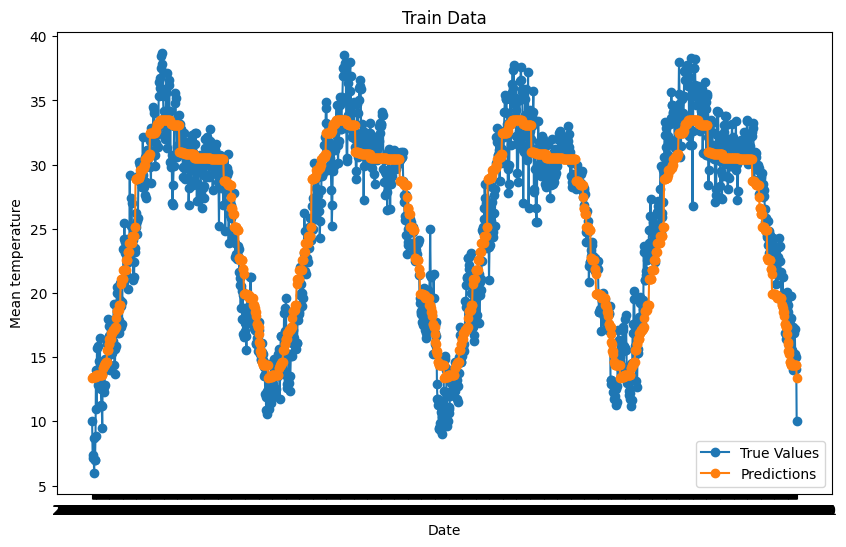

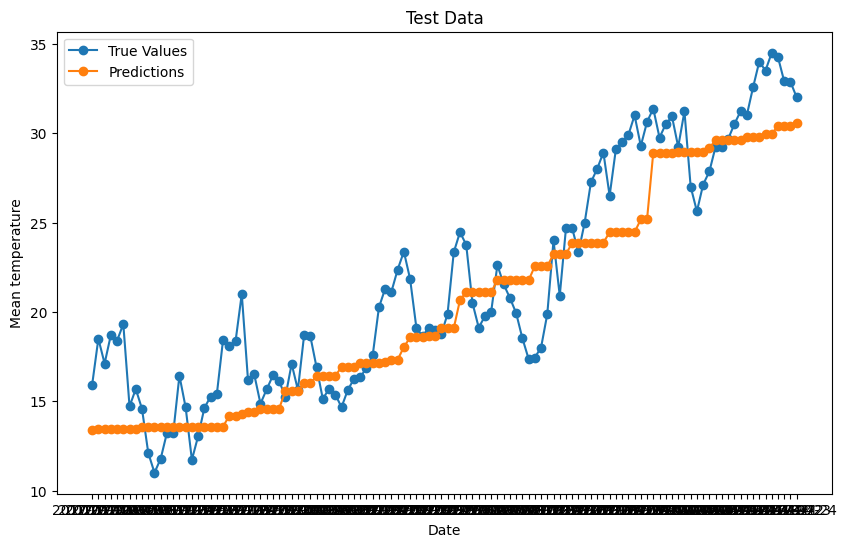

In [14]:
def plot_predictions(period, pred, y_true, label):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', marker='o')
    plt.plot(period, pred, label='Predictions', marker='o')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Mean temperature')
    plt.title(label)

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()

plot_predictions(train['date'], train_pred, y_train, 'Train Data')
plot_predictions(test['date'], test_pred, y_test, 'Test Data')


## Feature Importance

In [15]:
feature_importances = cat_boost.best_estimator_.get_feature_importance().round(3)
dict(zip(X_train.columns, feature_importances))

{'month': 20.799, 'quarter': 15.404, 'day_of_year': 63.798}

## Future predictions

In [16]:
from datetime import datetime, timedelta

def preprocess_future_data(data): # return X
    data['date'] = pd.to_datetime(data['date'])
    data['month'] = data['date'].dt.month
    data['day_of_year'] = data['date'].dt.day_of_year
    data['quarter'] = data['date'].dt.quarter
    X = data[['month', 'day_of_year', 'quarter']]
    return X

# Define the start and end dates
start_date = datetime(2023, 12, 1)
end_date = datetime(2023, 12, 3)

# Generate a list of dates from start_date to end_date
date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

# Create a DataFrame with a date column
future_data = pd.DataFrame({'date': date_range})
preprocess_future_data(future_data)
future_data

date  month  day_of_year  quarter
0 2023-12-01     12          335        4
1 2023-12-02     12          336        4
2 2023-12-03     12          337        4

In [17]:
future_pred = cat_boost.predict(future_data)

In [18]:
future_pred

array([19.08960443, 19.08960443, 19.08960443])

## What's next?

1. Find more historical data (consider the impact of global warming).

2. Adjust model parameters.

3. Generate additional features. For instance, incorporate data from 
the previous N days.<br>
When predicting tomorrow's weather, leveraging information,<br>
from today and the past N days can be particularly useful.